In [1]:
import mmcv
mmcv.collect_env()

from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

import os
import random
import cv2

/home/allanlago/anaconda3/envs/rt-flight/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
def load_model(config_file, checkpoint_file, device='cuda'):
    config = mmcv.Config.fromfile(config_file)
    config.model.pretrained = None

    model = build_detector(config.model)
    checkpoint = load_checkpoint(model, checkpoint_file, map_location=device)

    model.CLASSES = checkpoint['meta']['CLASSES']
    model.cfg = config
    model.to(device)

    return model

In [3]:
config_file = 'oriented_rcnn_r50_fpn_1x_dota_le90.py'
checkpoint_file = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

device = 'cuda'

model = load_model(config_file, checkpoint_file, device=device)
model.eval();

/home/allanlago/Documents/jupyter-notebooks/rt-flight/examples/mmdetection/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


In [4]:
def get_bboxes(model, img, min_confidence=0.3):
    padded_img = np.zeros((1024, 1024, 3))
    padded_img[:img.shape[0], :img.shape[1], :] = img
    img = padded_img
    vehicle_classes = [i for i, c in enumerate(model.CLASSES) if 'vehicle' in c]

    inference = inference_detector(model, img)
    bboxes = [inference[index] for index in vehicle_classes]

    bboxes = np.concatenate(bboxes, axis=0)
    bboxes = bboxes[bboxes[:, 5] > min_confidence]

    # the bboxes are in a weird polygonal format, so we convert them to rectangles
    rect_bboxes = np.array([
        bboxes[:, 1] - bboxes[:, 2]//2,
        bboxes[:, 1] + bboxes[:, 2]//2,
        bboxes[:, 0] - bboxes[:, 2]//2,
        bboxes[:, 0] + bboxes[:, 3],
        100*bboxes[:, -1],  # confidence score
    ]).astype(int).T

    # follows the format of x0, x1, y0, y1, confidence
    return rect_bboxes

In [5]:
img = '../data/demo.jpg'
results = inference_detector(model, img)

/home/allanlago/Documents/jupyter-notebooks/rt-flight/examples/mmdetection/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


In [6]:
img_pil = np.asarray(Image.open(img))
bboxes = get_bboxes(model, img_pil)

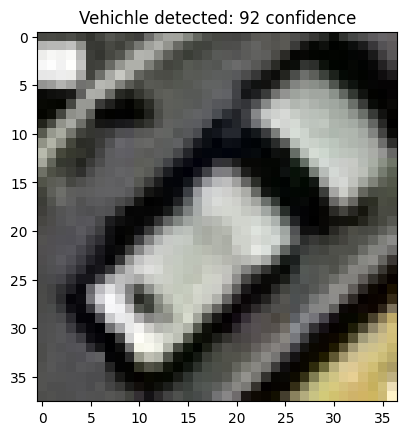

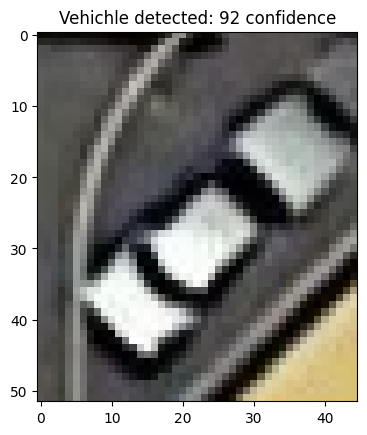

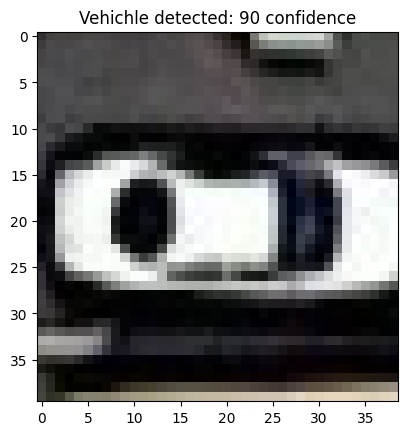

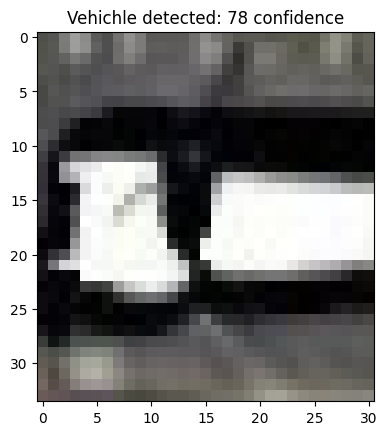

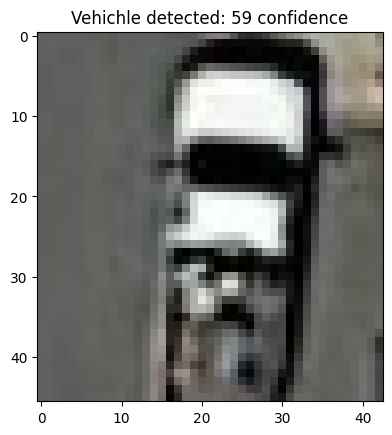

In [7]:
for bbox in bboxes[:5]:
    plt.title(f"Vehichle detected: {bbox[-1]} confidence")
    plt.imshow(img_pil[bbox[0]:bbox[1], bbox[2]:bbox[3]])
    plt.show()

In [8]:
def generate_random_gcps(img, num_samples, padding=(0, 0)):
    return np.random.randint(padding, 
                            high=(img.shape[0] - padding[0], img.shape[1] - padding[1]),
                            size=(num_samples, 2))

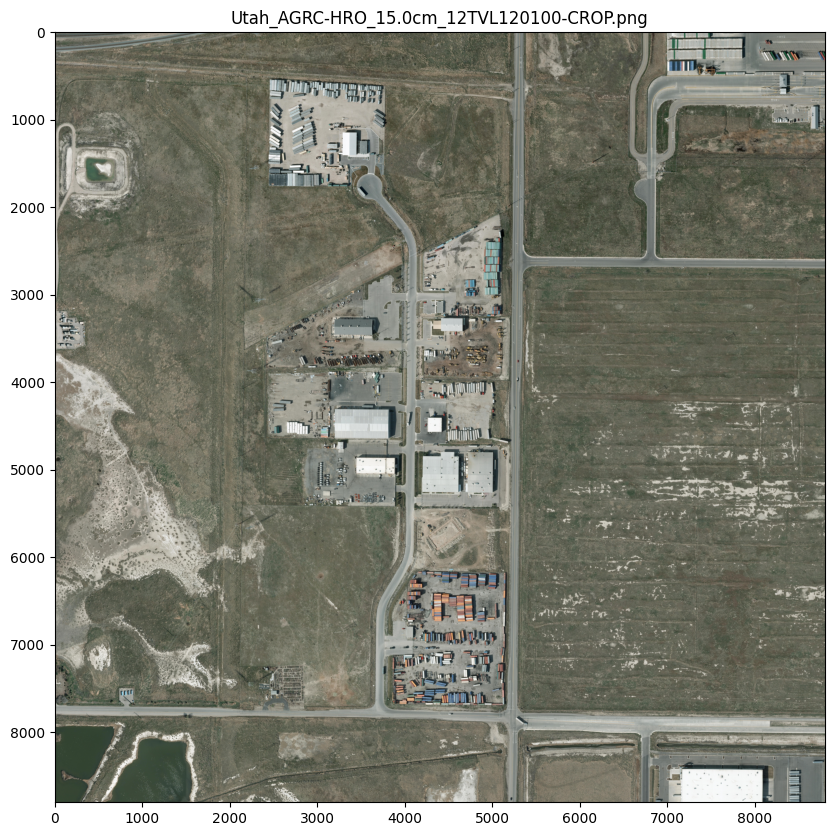

In [9]:
image_path = random.choice(os.listdir('../data'))
img = np.asarray(Image.open(f"../data/{image_path}").convert("RGB"))
# img = img_pil
plt.figure(figsize=(10, 10))
plt.title(image_path)
plt.imshow(img)

In [10]:
output_dim = (800, 800)
diag_len = np.ceil(np.sqrt(output_dim[0]**2 + output_dim[1]**2))
gcps = generate_random_gcps(img, 10, padding=(diag_len, diag_len))

In [11]:
def crop_around(img, centers, dim):
    x = centers.T[1] - dim[1] // 2
    y = centers.T[0] - dim[0] // 2
    return [img[p[0]:p[0]+dim[0], p[1]:p[1]+dim[1]] for p in zip(y, x)]

def center_crop(img, dim):
    return img[img.shape[0] // 2 - dim[0] // 2:img.shape[0] // 2 + dim[0] // 2,
               img.shape[1] // 2 - dim[1] // 2:img.shape[1] // 2 + dim[1] // 2]

In [12]:
def build_path(input_img, gcps, sample_dim, with_imgs=True):
    delta = np.diff(gcps, axis=0)
    directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
    angles = np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
    delta_angles = np.append(np.diff(angles), 0)

    sample_diag = np.floor(np.sqrt(sample_dim[0] ** 2 + sample_dim[1] ** 2)).astype("uint32")
    path = []

    if with_imgs:
        path_imgs = []
    
    for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
        steps = np.linalg.norm(t2 - t1) / 90  # segment_length / pixels_per_shot
        line = np.linspace(t1, t2, steps.astype('uint32'), dtype="uint32")
        path.extend([np.array([x, y, angle]) for (x, y) in line])

        if not with_imgs:
            continue

        # create image samples with appropriate rotation
        sample = crop_around(input_img, line, (sample_diag, sample_diag))
        rotated_sample = [center_crop(rotate(s, -angle, reshape=False), sample_dim) for s in sample]
        path_imgs.extend(rotated_sample)

        if delta_angle == 0:
            continue
    
        # end of segment, mock changing direction in place
        interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
        path.extend([np.array([line[-1][0], line[-1][1], theta]) for theta in interpolated_angles])
        path_imgs.extend([center_crop(rotate(sample[-1], -theta, reshape=False), sample_dim) for theta in interpolated_angles])
    
    return np.array(path), np.array(path_imgs)

In [13]:
trace, imgs = build_path(img, gcps, output_dim)

In [14]:
sequence_bbs = []

for cropped_img, center in zip(imgs[:30], trace[:, :2]):
    bboxes = get_bboxes(model, cropped_img)
    
    if len(bboxes) == 0:
        sequence_bbs.append(np.array([]))
        continue

    offset = center.astype(int) - np.array(output_dim) // 2
    bboxes[:, :4] += np.array([offset[0], offset[0], offset[1], offset[1]])

    sequence_bbs.append(bboxes)

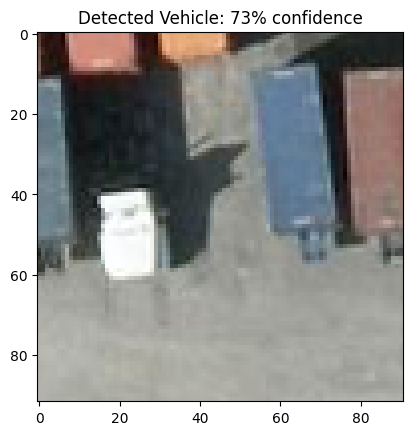

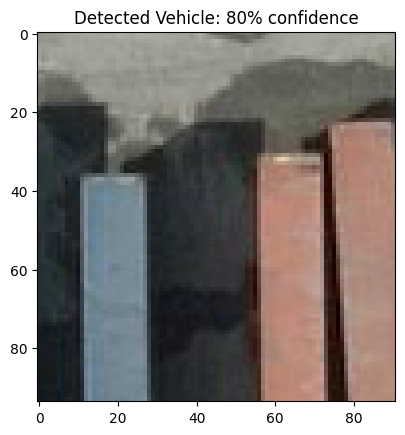

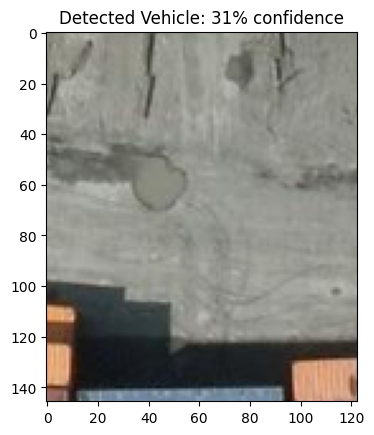

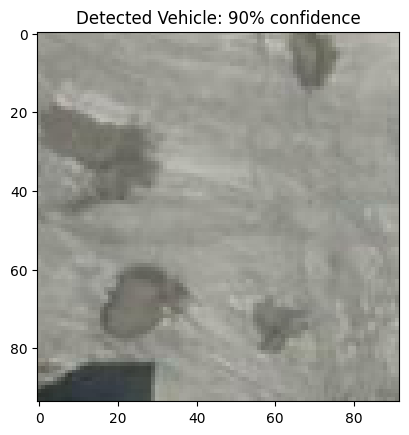

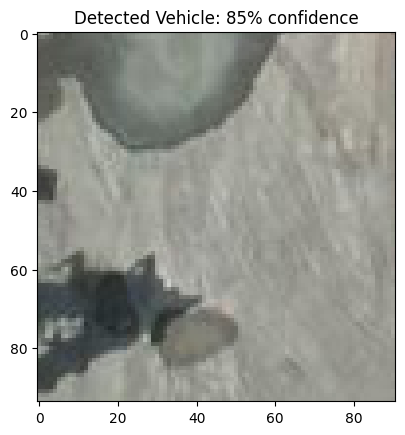

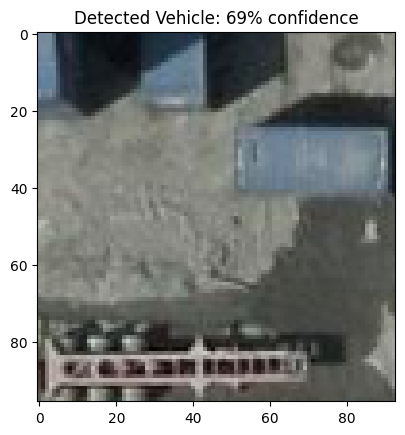

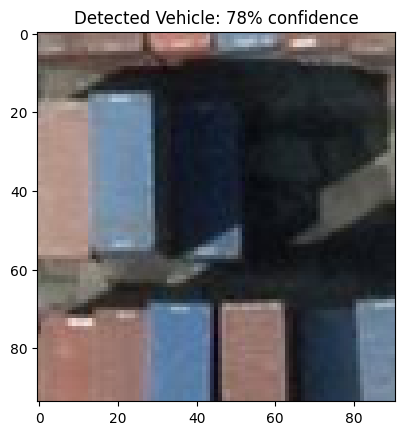

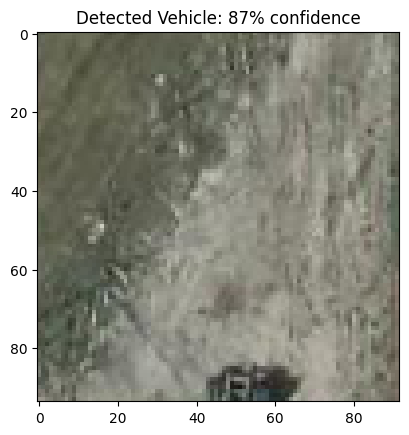

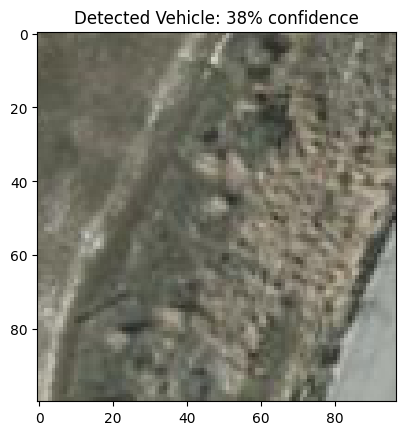

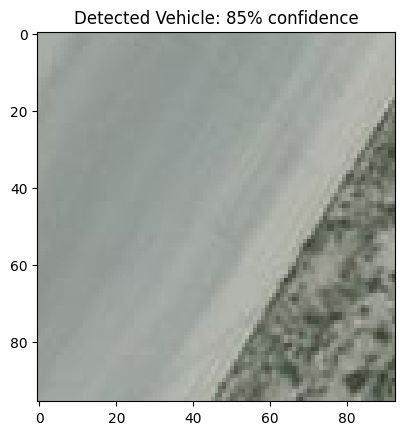

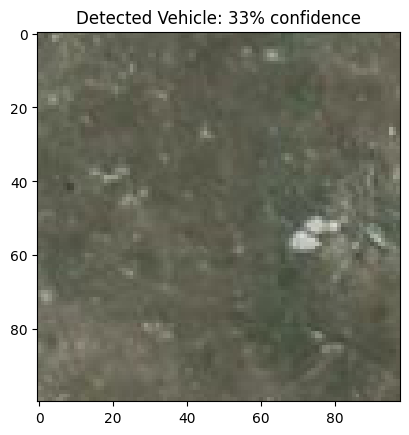

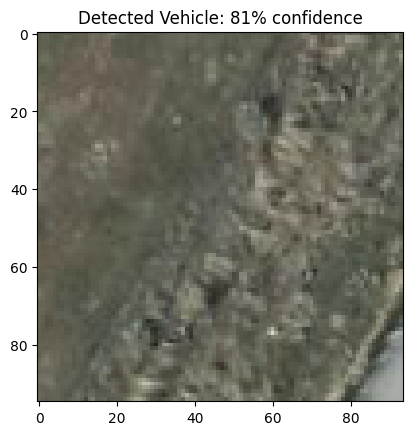

In [15]:
for img_bboxes in sequence_bbs:
    for bbox in img_bboxes:
        plt.imshow(img[bbox[0]-30:bbox[1]+30, bbox[2]-30:bbox[3]+30])
        plt.title(f"Detected Vehicle: {bbox[-1]}% confidence")
        plt.show()